In [68]:
import os
import sys
# Here you need to have same Python version on your local machine and on worker node i.e. EC2. here both should have python3.
os.environ["PYSPARK_PYTHON"] = "/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

In [69]:

#Importing all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
from pyspark.sql.functions import *

#Creating Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('CreditCard_Approval').getOrCreate()

# Data Preprocessing

In [70]:
#Reading Data from a CSV file 
#Inferring Schema and Setting Header as True
df1=spark.read.csv('application_record.csv', header=True, inferSchema=True)
#Printing Schema
df1.printSchema()

[Stage 100:>                                                        (0 + 2) / 2]

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)



As we can see the variable CNT_FAM_MEMBER is given as double integer. it is clear that number of people cannot be a decimal or float number. So the datatype need to be cast as an integer.

In [71]:
#Convert the datatype of the column
#Casting CNT_FAM_MEMBERS into integer

from pyspark.sql.types import * 
df1 = df1.withColumn('CNT_FAM_MEMBERS', df1['CNT_FAM_MEMBERS'].cast(IntegerType()))

In [72]:
#Reading Data from a CSV file 
#Inferring Schema and Setting Header as True
df2=spark.read.csv('credit_record.csv', header=True, inferSchema=True)
#Printing Schema
df2.printSchema()

[Stage 102:============================>                            (1 + 1) / 2]

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



In [73]:
#Data samples
df1.show(2)

+-------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+-------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|5008804|          M|           Y|              Y|           0|        427500.0|         Working|   Higher education|    Civil marriage| Rented apartment|    -12005|        -4542|         1|              1|         0|

In [74]:
#Statistically summarizing about the data of df1
df1.describe().show()

[Stage 104:============================>                            (1 + 1) / 2]

+-------+-----------------+-----------+------------+---------------+-------------------+------------------+--------------------+--------------------+------------------+-----------------+-------------------+-----------------+----------+------------------+-------------------+-------------------+--------------------+-----------------+
|summary|               ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|       CNT_CHILDREN|  AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|         DAYS_BIRTH|    DAYS_EMPLOYED|FLAG_MOBIL|   FLAG_WORK_PHONE|         FLAG_PHONE|         FLAG_EMAIL|     OCCUPATION_TYPE|  CNT_FAM_MEMBERS|
+-------+-----------------+-----------+------------+---------------+-------------------+------------------+--------------------+--------------------+------------------+-----------------+-------------------+-----------------+----------+------------------+-------------------+-------------------+--------------------+-----------------

It can be seen that the variable DAYS_BIRTH and DAYS_EMPLOYED are number of days calcualted backwards. Those variables need to be transormed for proper statistical study. 

In [75]:
#Statistically summarizing about the data of df2
df2.describe().show()

[Stage 106:============================>                            (1 + 1) / 2]

+-------+------------------+-------------------+-------------------+
|summary|                ID|     MONTHS_BALANCE|             STATUS|
+-------+------------------+-------------------+-------------------+
|  count|           1048575|            1048575|            1048575|
|   mean| 5068286.424673486|-19.136998307226474|0.05824863961501482|
| stddev|46150.578505349535| 14.023497688326477| 0.3949878642052491|
|    min|           5001711|                -60|                  0|
|    max|           5150487|                  0|                  X|
+-------+------------------+-------------------+-------------------+



## Checking for duplicate rows
### application_records dataset

In [76]:
#Checking for duplicate rows
df1.groupBy(df1.columns).count().where(col('count') > 1).select(sum('count')).show()

[Stage 109:========================================>            (153 + 2) / 200]

+----------+
|sum(count)|
+----------+
|      null|
+----------+



There are no duplicate rows present

In [77]:
df2.groupBy(df2.columns).count().where(col('count') > 1).select(sum('count')).show()

[Stage 112:=============================================>       (173 + 2) / 200]

+----------+
|sum(count)|
+----------+
|      null|
+----------+



There are no duplicate rows present

## Handling Missing and Null values

### application_records dataset

In [78]:
# Get count of nan or missing values of df1
df1.select([count(when(isnan(c), c)).alias(c) for c in df1.columns]).show()

[Stage 114:============================>                            (1 + 1) / 2]

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|            0|         0|              0|         0|         0|     

There are no missing values in df1.

In [79]:
### Get count of null values of df1
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

[Stage 116:>                                                        (0 + 2) / 2]

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|            0|         0|              0|         0|         0|     

There is 134203 null values in column OCCUPATION_TYPE of df1. This need to be handled. 

In [80]:
#grouping column "OCCUPATION_TYPE" based on count
df1.groupby(["OCCUPATION_TYPE"]).count().sort(desc("count")).show()

+--------------------+------+
|     OCCUPATION_TYPE| count|
+--------------------+------+
|                null|134203|
|            Laborers| 78240|
|          Core staff| 43007|
|         Sales staff| 41098|
|            Managers| 35487|
|             Drivers| 26090|
|High skill tech s...| 17289|
|         Accountants| 15985|
|      Medicine staff| 13520|
|       Cooking staff|  8076|
|      Security staff|  7993|
|      Cleaning staff|  5845|
|Private service s...|  3456|
|  Low-skill Laborers|  2140|
|         Secretaries|  2044|
|Waiters/barmen staff|  1665|
|       Realty agents|  1041|
|            HR staff|   774|
|            IT staff|   604|
+--------------------+------+



Null values in OCCUPATION_TYPE only points to people who didnt mentioned it. Either their proffesion was not mentioned in the options available or they didnt want to divulge it. These null values are mapped to a new variable "Not Mentioned", and thus handled.

In [81]:
# replace the null values in the columns "OCCUPATION_TYPE" with 'Not mentioned' using the withColumn and when functions
df1 = df1.withColumn("OCCUPATION",when(df1["OCCUPATION_TYPE"].isNull(), "Not Mentioned").otherwise(df1["OCCUPATION_TYPE"]))

In [82]:
df1.groupby(["OCCUPATION"]).count().sort(desc("count")).show()

[Stage 120:============================>                            (1 + 1) / 2]

+--------------------+------+
|          OCCUPATION| count|
+--------------------+------+
|       Not Mentioned|134203|
|            Laborers| 78240|
|          Core staff| 43007|
|         Sales staff| 41098|
|            Managers| 35487|
|             Drivers| 26090|
|High skill tech s...| 17289|
|         Accountants| 15985|
|      Medicine staff| 13520|
|       Cooking staff|  8076|
|      Security staff|  7993|
|      Cleaning staff|  5845|
|Private service s...|  3456|
|  Low-skill Laborers|  2140|
|         Secretaries|  2044|
|Waiters/barmen staff|  1665|
|       Realty agents|  1041|
|            HR staff|   774|
|            IT staff|   604|
+--------------------+------+



In [83]:
#dropping occupation_type column
df1 = df1.drop('OCCUPATION_TYPE')

In [84]:
### rechecking null values of df1
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()

[Stage 122:>                                                        (0 + 2) / 2]

+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+----------+
| ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|CNT_FAM_MEMBERS|OCCUPATION|
+---+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+----------+
|  0|          0|           0|              0|           0|               0|               0|                  0|                 0|                0|         0|            0|         0|              0|         0|         0|              0|    

### credits_record dataset

In [85]:
### Get count of missing values of df2
df2.select([count(when(isnan(c), c)).alias(c) for c in df2.columns]).show()

[Stage 124:============================>                            (1 + 1) / 2]

+---+--------------+------+
| ID|MONTHS_BALANCE|STATUS|
+---+--------------+------+
|  0|             0|     0|
+---+--------------+------+



In [86]:
### Get count of null values of df2
df2.select([count(when(col(c).isNull(), c)).alias(c) for c in df2.columns]).show()

[Stage 126:============================>                            (1 + 1) / 2]

+---+--------------+------+
| ID|MONTHS_BALANCE|STATUS|
+---+--------------+------+
|  0|             0|     0|
+---+--------------+------+



There are no missing values as well as null values.

## Handling Ouliers

### application_record dataset

Before looking for outliers variables DAYS_BIRTH and DAYS_EMPLOYED need to be transformed properly. They are given as negative values mostly since they are calcualted from current date and backwards. These variables are transformed into AGE and YEARS_EMPLOYED since they are more meaningful and insightful.

In [87]:
#Creating new varaibles to calculate age and employment years
df1=df1.withColumn("AGE", df1["DAYS_BIRTH"]/-365.25)
df1=df1.withColumn("YEARS_EMPLOYED", df1["DAYS_EMPLOYED"]/-365.25)

In [88]:
#casting proper data types
df1=df1.withColumn("AGE", df1["AGE"].cast(IntegerType()))
df1=df1.withColumn("YEARS_EMPLOYED", df1["YEARS_EMPLOYED"].cast(IntegerType()))

In [89]:
#dropping columns
df1 = df1.drop('DAYS_BIRTH', 'DAYS_EMPLOYED')

In [90]:
#Exploring the numerical variables of df1
num_col=["CNT_CHILDREN", "AMT_INCOME_TOTAL","AGE","YEARS_EMPLOYED", "CNT_FAM_MEMBERS"]
df1.describe(num_col).show()

+-------+-------------------+------------------+------------------+-------------------+-----------------+
|summary|       CNT_CHILDREN|  AMT_INCOME_TOTAL|               AGE|     YEARS_EMPLOYED|  CNT_FAM_MEMBERS|
+-------+-------------------+------------------+------------------+-------------------+-----------------+
|  count|             438557|            438557|            438557|             438557|           438557|
|   mean|0.42739028222101116| 187524.2860095039| 43.29556933306275|-166.06286754059334|2.194465029631268|
| stddev|  0.724882213552146|110086.85306622987|11.459524841950026| 379.36581084243477|0.897207330056299|
|    min|                  0|           26100.0|                20|               -999|                1|
|    max|                 19|         6750000.0|                68|                 47|               20|
+-------+-------------------+------------------+------------------+-------------------+-----------------+



Its clear from the above statistical summary that outiers do exist and need to be handled. Variables AGE and YEARS_EMPLOYED are tranformed.

In [91]:
#Exploring CNT_CHILDREN variables
#Getting the count of the values
df1.groupby("CNT_CHILDREN").count().sort(desc("count")).show()

+------------+------+
|CNT_CHILDREN| count|
+------------+------+
|           0|304071|
|           1| 88527|
|           2| 39884|
|           3|  5430|
|           4|   486|
|           5|   133|
|           7|     9|
|           9|     5|
|          12|     4|
|           6|     4|
|          14|     3|
|          19|     1|
+------------+------+



As we can see only a small fraction have no.of children more than 5. The other rows which pose as a outlier need to be dropped since is only a small fraction of data.

In [92]:
#Dropping rows with outliers
df1=df1.filter("CNT_CHILDREN not in (7,9,6,12,14,19)")

In [93]:
#rechecking the column
df1.groupby("CNT_CHILDREN").count().sort(desc("count")).show()

+------------+------+
|CNT_CHILDREN| count|
+------------+------+
|           0|304071|
|           1| 88527|
|           2| 39884|
|           3|  5430|
|           4|   486|
|           5|   133|
+------------+------+



In [94]:
#Exploring CNT_FAM_MEMBERS variables
#Getting the count of the values
df1.groupby("CNT_FAM_MEMBERS").count().sort(desc("count")).show()

[Stage 134:>                                                        (0 + 2) / 2]

+---------------+------+
|CNT_FAM_MEMBERS| count|
+---------------+------+
|              2|233891|
|              1| 84492|
|              3| 77128|
|              4| 37356|
|              5|  5081|
|              6|   459|
|              7|   124|
+---------------+------+



As we dealt with the CNT_CHILDREN column CNT_FAM_MEMBERS column also got handled, which is expected. 

More statistical summary on numerical variables to see how the data distribution is and how to eliminate the outliers.

In [95]:
 '''
 Credits for the below function:
 author: Ming Chen and Wenqiang Feng
    :email:  von198@gmail.com
    
    
    Function to union the basic stats results and deciles
    :param df_in: the input dataframe
    :param columns: the cloumn name list of the numerical variable
    :param deciles: the deciles output

    :return : the numerical describe info. of the input dataframe

  '''
def describe_pd(df_in, columns, deciles=False):
    if deciles:
        percentiles = np.array(range(0, 105, 5))
    else:
        percentiles = [25, 50, 75]

    percs = np.transpose([np.percentile(df_in.select(x).collect(), percentiles) for x in columns])
    percs = pd.DataFrame(percs, columns=columns)
    percs['summary'] = [str(p) + '%' for p in percentiles]

    spark_describe = df_in.describe().toPandas()
    new_df = pd.concat([spark_describe, percs],ignore_index=True)
    new_df = new_df.round(2)
    return new_df[['summary'] + columns]

In [96]:
#Exploring the percentiles of numerical variables.
describe_pd(df1,num_col, deciles=True)

,summary,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE,YEARS_EMPLOYED,CNT_FAM_MEMBERS
0,count,438531,438531,438531,438531,438531
1,mean,0.42686605964002544,187524.3934852268,43.29559825873199,-166.07316244461623,2.1939361185412207
2,stddev,0.7212551276036635,110087.6523460658,11.45979945769183,379.3746976264153,0.8942988332908555
3,min,0,26100.0,20,-999,1
4,max,5,6750000.0,68,47,7
5,0%,0.0,26100.0,20.0,-999.0,1.0
6,5%,0.0,76500.0,27.0,-999.0,1.0
7,10%,0.0,90000.0,28.0,-999.0,1.0
8,15%,0.0,108000.0,30.0,-999.0,1.0
9,20%,0.0,112500.0,32.0,0.0,2.0


As expected the AMT_INCOME_TOTAL have outliers above the 95th percentile. 

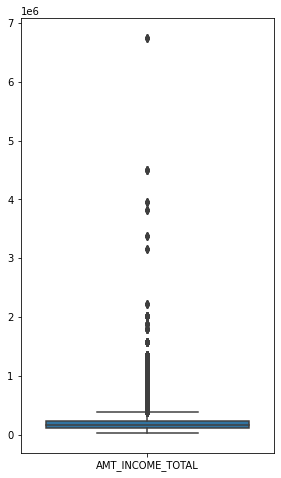

In [97]:
#Ploting box plot for AMT_INCOME_TOTAL
x = df1.select("AMT_INCOME_TOTAL").toPandas()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

The existence of outliers as indicated by both the summary ststistics and the box plot will be dealt by removing the values above the 95% block.

In [98]:
#dropping rows with outliers
df1=df1.filter("not(AMT_INCOME_TOTAL > 360000)")

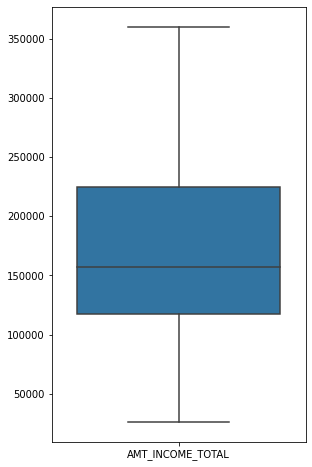

In [99]:
#Ploting box plot for AMT_INCOME_TOTAL

x = df1.select("AMT_INCOME_TOTAL").toPandas()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

The annual incone variable is dealt properly. 

Similar to this the YEAR_EMLOYED variable too have anomalies. On closer inspection it can be seen that a value of -999  as no.of years is present in this column. This is illogical and so dropping those rows. 

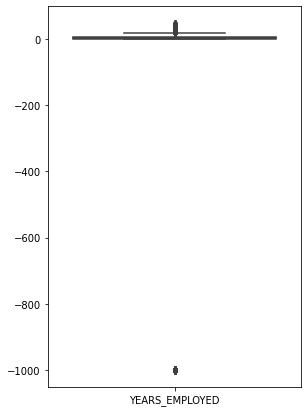

In [100]:
#Ploting box plot for YEARS_EMPLOYED
x = df1.select("YEARS_EMPLOYED").toPandas()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

In [101]:
#dropping ouliers rows from YEARS_EMPLOYED
df1=df1.filter("not(YEARS_EMPLOYED < 0)")

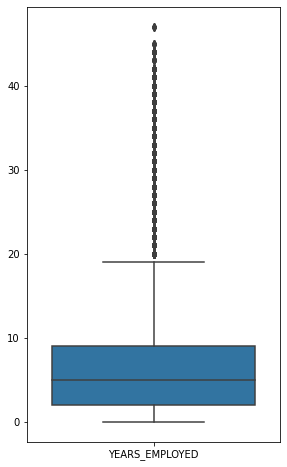

In [102]:
#Ploting box plot for YEARS_EMPLOYED
x = df1.select("YEARS_EMPLOYED").toPandas()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

# Label Encoding

In [103]:
#columns with categorical variables
cat_cols=["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","FLAG_WORK_PHONE","FLAG_PHONE","FLAG_EMAIL","OCCUPATION"]
df=df1.select(cat_cols)

# find the number of catagories in categorical variables columns 
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).show()

[Stage 147:============================>                            (1 + 1) / 2]

+-----------+------------+---------------+----------------+-------------------+------------------+-----------------+---------------+----------+----------+----------+
|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION|
+-----------+------------+---------------+----------------+-------------------+------------------+-----------------+---------------+----------+----------+----------+
|          2|           2|              2|               5|                  5|                 5|                6|              2|         2|         2|        19|
+-----------+------------+---------------+----------------+-------------------+------------------+-----------------+---------------+----------+----------+----------+



In [104]:
# import necessary library for label encoding
from pyspark.ml.feature import *

#Running string indexer on the columns which are categorical but are represented by strings.
#adding a string on the end of the output column to make it easy to identify
stringCols =["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION"]
for c in stringCols:
    outCol = c + '_ix'
    si = StringIndexer(inputCol=c, outputCol=outCol)
    df1 = si.fit(df1).transform(df1)

In [105]:
#checking schema of encoded dataset
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- CNT_FAM_MEMBERS: integer (nullable = true)
 |-- OCCUPATION: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- YEARS_EMPLOYED: integer (nullable = true)
 |-- CODE_GENDER_ix: double (nullable = false)
 |-- FLAG_OWN_CAR_ix: double (nullable = false)
 |-- FLAG_OWN_REALTY_ix: double (nullable = false)
 |-- NAME_INCOME_TYPE_ix: double (nulla

# Exploratory Data Analysis
## Univariate Analysis

### applications_record

In [106]:
#Exploring CODE_GENDER variable in df1 dataset
df1.groupby("CODE_GENDER").count().sort(desc("count")).show()

21/07/21 12:30:32 WARN Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.
[Stage 166:>                                                        (0 + 2) / 2]

+-----------+------+
|CODE_GENDER| count|
+-----------+------+
|          F|221475|
|          M|123678|
+-----------+------+



M    35.832805
F    64.167195
Name: CODE_GENDER, dtype: float64


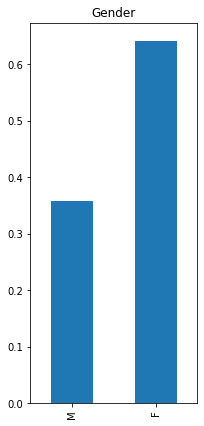

In [107]:
#plotting barplot of CODE_GENDER variable
plt.figure(figsize=(3,7))
x = df1.select("CODE_GENDER").toPandas()
z=x.CODE_GENDER.value_counts(sort=False, normalize=True)*100
print(z)
x.CODE_GENDER.value_counts(sort=False, normalize=True).plot(kind = 'bar', title="Gender")
plt.show()

Around 64% of applicants are females.

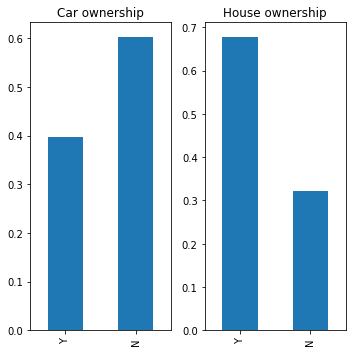

In [108]:
#Exploring FLAG_OWN_CAR and FLAG_OWN_REALTY together
#plotting barplots

plt.figure(figsize=(5,5))
# Car ownership
plt.subplot(1,2,1)
car = df1.select("FLAG_OWN_CAR").toPandas()
car.FLAG_OWN_CAR.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Car ownership")

# House ownership
plt.subplot(1,2,2)
realty= df1.select("FLAG_OWN_REALTY").toPandas()
realty.FLAG_OWN_REALTY.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="House ownership")
plt.tight_layout()

Around 60% or applicants dont own a car and around 68% applicants have house ownership.

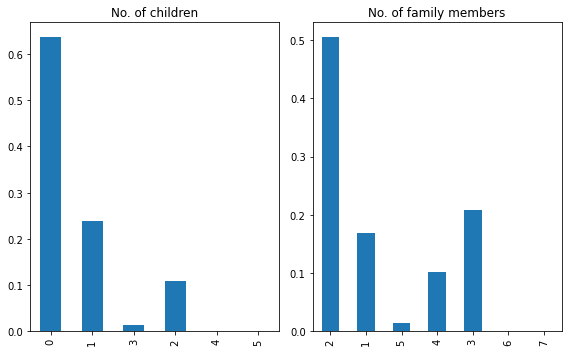

In [109]:
#Exploring CNT_CHILDREN and CNT_FAM_MEMBERS together
#plotting barplots

plt.figure(figsize=(8,5))
# Count of children
plt.subplot(1,2,1)
x = df1.select("CNT_CHILDREN").toPandas()
x.CNT_CHILDREN.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="No. of children")

#Annual Income
plt.subplot(1,2,2)
x = df1.select("CNT_FAM_MEMBERS").toPandas()
x.CNT_FAM_MEMBERS.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="No. of family members")

plt.tight_layout()

About 60% of applicants have no children and arounf 50% have only 2 family members.

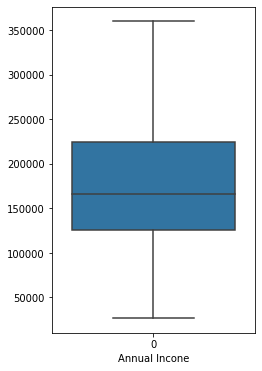

In [110]:
#plotting boxplot of AMT_INCONE_TOTAL variable
x = df1.select("AMT_INCOME_TOTAL").toPandas()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x.AMT_INCOME_TOTAL)
plt.xlabel("Annual Incone")
plt.show()

Thr varaible has been dealt in detail during the outlier treatment

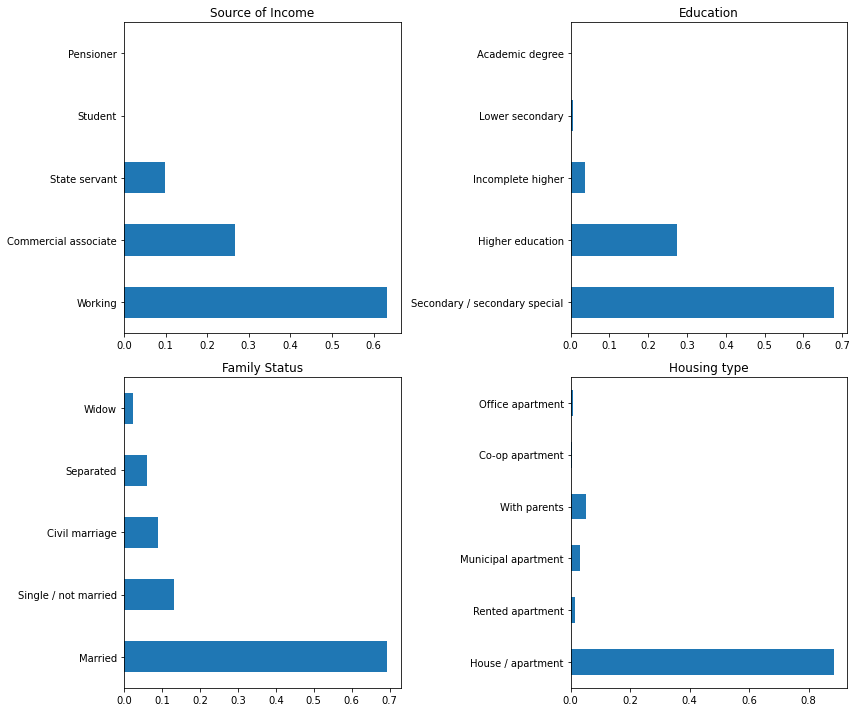

In [111]:
#Exploring NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE variables together
#plotting barplots

plt.figure(figsize=(12,10))
#Source of incone
plt.subplot(2,2,1)
inc= df1.select("NAME_INCOME_TYPE").toPandas()
inc.NAME_INCOME_TYPE.value_counts(sort=False,normalize=True).plot(kind = 'barh', title="Source of Income")

# Educational level
plt.subplot(2,2,2)
edu= df1.select("NAME_EDUCATION_TYPE").toPandas()
edu.NAME_EDUCATION_TYPE.value_counts(sort=False,normalize=True).plot(kind = 'barh', title="Education")

#Family Status
plt.subplot(2,2,3)
fam= df1.select("NAME_FAMILY_STATUS").toPandas()
fam.NAME_FAMILY_STATUS.value_counts(sort=False,normalize=True).plot(kind = 'barh', title="Family Status")

#Housing Type
plt.subplot(2,2,4)
h= df1.select("NAME_HOUSING_TYPE").toPandas()
h.NAME_HOUSING_TYPE.value_counts(sort=False,normalize=True).plot(kind = 'barh', title="Housing type")

plt.tight_layout()

Around 62% of applicant's source of income is employent. 77% of applicats are Secondary level educated and 70% are married. ALmost 90% of appicants lives at their own house/apartment

In [112]:
#Exploring FLAG_MOBIL variable in df1 dataset
df1.groupby("FLAG_MOBIL").count().sort(desc("count")).show()

[Stage 178:============================>                            (1 + 1) / 2]

+----------+------+
|FLAG_MOBIL| count|
+----------+------+
|         1|345153|
+----------+------+



All the credit card appliers have a mobile number with them.
Since that column have only one value, that column can be dropped, since it will create bias in the model. 

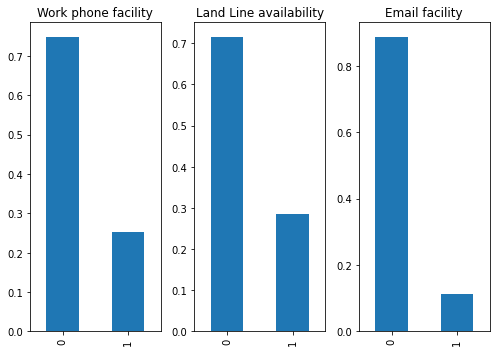

In [113]:
#Exploring FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL variables together
#plotting barplots

plt.figure(figsize=(7,5))
#Phone
plt.subplot(1,3,1)
inc= df1.select("FLAG_WORK_PHONE").toPandas()
inc.FLAG_WORK_PHONE.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Work phone facility")

# Email
plt.subplot(1,3,2)
edu= df1.select("FLAG_PHONE").toPandas()
edu.FLAG_PHONE.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Land Line availability")

#work phone
plt.subplot(1,3,3)
fam= df1.select("FLAG_EMAIL").toPandas()
fam.FLAG_EMAIL.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Email facility")


plt.tight_layout()

75% applicanats dont have facility of work phone. Around 70% have no land line access and about 85% have no email

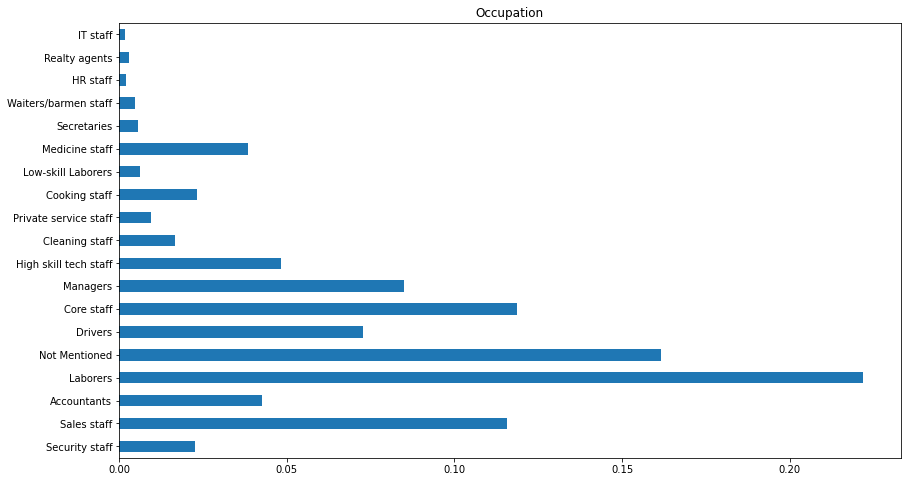

In [114]:
#Exploring OCCUPATION variable
#plotting barplot
x = df1.select("OCCUPATION").toPandas()
plt.figure(figsize=(14,8))
x.OCCUPATION.value_counts(sort=False,normalize=True).plot(kind = 'barh',title="Occupation")
plt.show()

Around 23% of applicants are labourers.

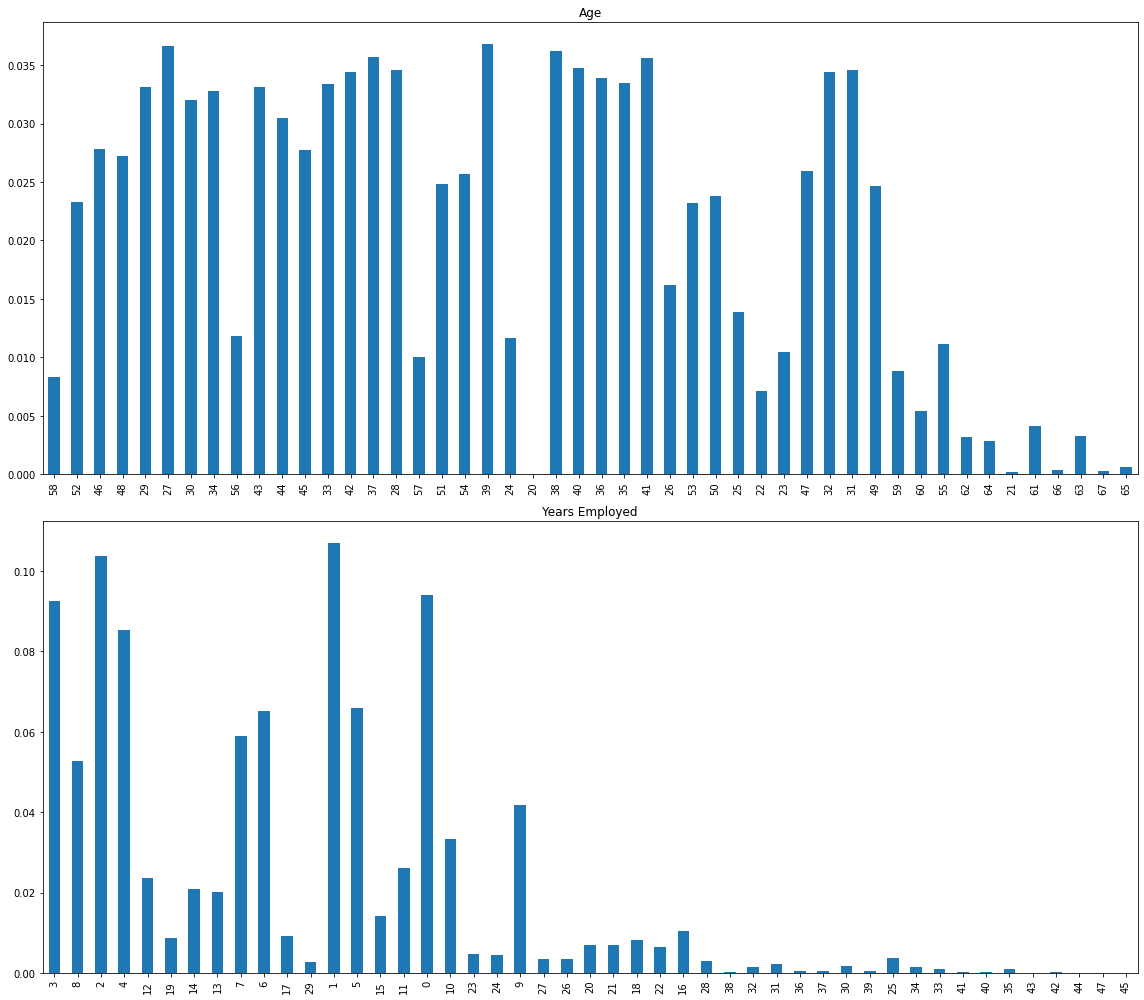

In [115]:
#Exploring AGE & YEARS_EMPLOYED variables together
#plotting barplots
plt.figure(figsize=(16,14))
#Age
plt.subplot(2,1,1)
a= df1.select("AGE").toPandas()
a.AGE.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Age")

#Years employed
plt.subplot(2,1,2)
edu= df1.select("YEARS_EMPLOYED").toPandas()
edu.YEARS_EMPLOYED.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Years Employed")

plt.tight_layout()

Most applicants are between the age of 27 to 44. 
About 11% of the applicants have only 1 year of work experience. 


### credits_record dataset

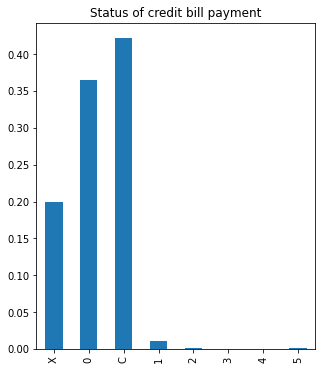

In [116]:
#Exploring the STATUS variable
#plotting barplot of the variable
x = df2.select("STATUS").toPandas()
plt.figure(figsize=(5,6))
x.STATUS.value_counts(sort=False,normalize=True).plot(kind = 'bar', title="Status of credit bill payment")
plt.show()

About 43% of the total credit card owners have cleared their dues.

## Bivariate analysis

### application_record
### Gender vs House Ownership

In [117]:
#Extracting the necessary columns for analysis
x=df1.select("CODE_GENDER","FLAG_OWN_REALTY")

#filterig the data to applicants who owns home
x=x.filter("FLAG_OWN_REALTY == 'Y' ").toPandas()

#finding the proportions
x["CODE_GENDER"].value_counts(normalize=True)*100

F    65.349849
M    34.650151
Name: CODE_GENDER, dtype: float64

Around 65% of females have houseownership compared to the mere 35% in the case of males

### Education vs Income

In [118]:
#Exploring relationship between Education and Income
q=df1.select("NAME_EDUCATION_TYPE", "AMT_INCOME_TOTAL")


# manually putting labels for each caetogory since label encoder will label according to alphabetical order of categories and educational levels are not aplhabetical in hierarchy
q=q.withColumn("EDUCATION", when(q["NAME_EDUCATION_TYPE"] =="Lower secondary", 1).when(q["NAME_EDUCATION_TYPE"] == "Secondary / secondary special", 2).when(q["NAME_EDUCATION_TYPE"] =="Incomplete higher",3).when(q["NAME_EDUCATION_TYPE"] =="Higher education", 4).otherwise(5))
#converting to pandas dataframe
r=q.toPandas()


#converting to salary
r["SALARY"]=r["AMT_INCOME_TOTAL"]/12

#dropping annual income column
r.drop('AMT_INCOME_TOTAL',axis='columns', inplace=True)

In [119]:
# education groupby avg salary
z=r.groupby(["EDUCATION"]).mean()
#resetting inder of dataframe
z=z.reset_index()
#print the result
print(z)

#calacualting the correlation
correlation = z["EDUCATION"]. corr(z["SALARY"]) 
print("Correlation value between Educational level and Incone is ",correlation)

   EDUCATION        SALARY
0          1  13369.514790
1          2  14102.137487
2          3  15741.220180
3          4  16621.880680
4          5  18297.554348
Correlation value between Educational level and Incone is  0.9922547141689341


As expeceted salary increases with better educational levels. 
This is indicated by the heavy positive correlation between both.

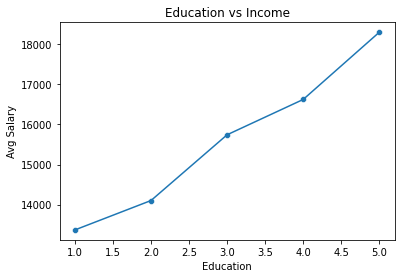

In [120]:
#plotiing scatterplot for education and income
sns.scatterplot(x="EDUCATION", y="SALARY", data=z)
plt.plot(z["EDUCATION"],z["SALARY"])
plt.title("Education vs Income")
plt.xlabel("Education")
plt.ylabel("Avg Salary")
plt.show()

### Mean and median of Salary

In [121]:
#Finding the average and median of salary
print("Average Salary of applicant base = ", r.SALARY.mean())
print("Median of salary of applicant base =", r.SALARY.median()) 

Average Salary of applicant base =  14855.269960126381
Median of salary of applicant base = 13875.0


### Family status vs Number of chidren

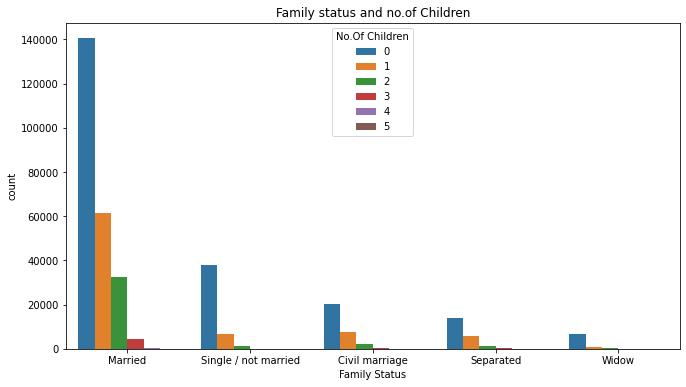

In [122]:
#Explorinf relationship between family status and no.of children
q=df1.select("NAME_FAMILY_STATUS", "CNT_CHILDREN").toPandas()

#plotting barplot
plt.figure(figsize=(11,6))
sns.countplot(x="NAME_FAMILY_STATUS", hue='CNT_CHILDREN', data=q)
plt.title("Family status and no.of Children")
plt.xlabel("Family Status")
plt.legend(title="No.Of Children")
plt.show()

Its crystal clear that most of the applicants who are married have no children OR are older couples (children who have a family of their own), which in turn implies the insight from univariate analysis of CNT_FAM_MEMBERS varaible, that majority of applicants have only 2 family members

### Occupation vs Income

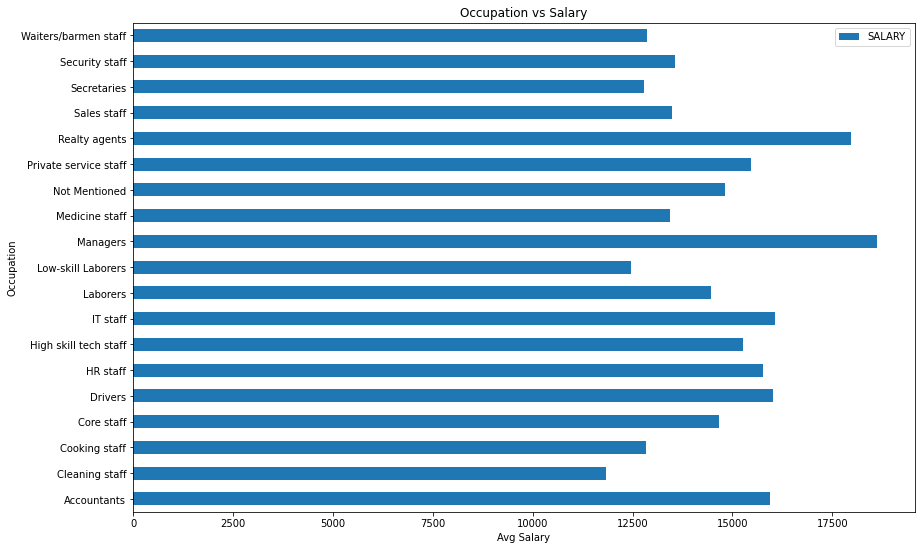

In [123]:
#Exploring relationship between Occupation and Income
q=df1.select("OCCUPATION", "AMT_INCOME_TOTAL").toPandas()

#converting to salary
q["SALARY"]=q["AMT_INCOME_TOTAL"]/12

#dropping annual income column
q.drop('AMT_INCOME_TOTAL',axis='columns', inplace=True)

#plotting barplot
q.groupby(["OCCUPATION"]).mean().plot(kind='barh', title="Occupation vs Salary", figsize=(14,9))
plt.ylabel("Occupation")
plt.xlabel("Avg Salary")
plt.show()

As assumed Managers are paid highest and cleaning staff the least

### Merged data

In [124]:
#merging application_record and credit_records
data=df1.join(df2, on="ID", how="inner")

In [125]:
#data samples
data.show(2)

[Stage 192:============================>                            (1 + 1) / 2]

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+------------------+-----------------+----------+---------------+----------+----------+---------------+----------+---+--------------+--------------+---------------+------------------+-------------------+----------------------+---------------------+--------------------+-------------+--------------+------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|CNT_FAM_MEMBERS|OCCUPATION|AGE|YEARS_EMPLOYED|CODE_GENDER_ix|FLAG_OWN_CAR_ix|FLAG_OWN_REALTY_ix|NAME_INCOME_TYPE_ix|NAME_EDUCATION_TYPE_ix|NAME_FAMILY_STATUS_ix|NAME_HOUSING_TYPE_ix|OCCUPATION_ix|MONTHS_BALANCE|STATUS|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+------------------+-----

According to the problem statement, the user IDs will be classified as delinquent, if the customer has ever delayed their payment by more than 60 days.  

In [126]:
#replacing vales of X and C from Status column to -1 and -2 
data=data.withColumn("STATUS", when(data["STATUS"]== "X", -1).when(data["STATUS"] == "C", -2).otherwise(data["STATUS"]))

#casting the datatype to integer
data=data.withColumn("STATUS", data["STATUS"].cast(IntegerType()))

#Creating a new variable for classifying customer based on deliquency
data=data.withColumn("DELIQUENT", when(data["STATUS"]== 2, 1).when(data["STATUS"]>2, 1).otherwise(0))

#dropping the status column
data=data.drop("STATUS")

In [127]:
#Exploring the new column deliquent
data.groupby("DELIQUENT").count().show()

+---------+------+
|DELIQUENT| count|
+---------+------+
|        1|  2096|
|        0|613835|
+---------+------+



Since the data is highly imbalanced, the following eda results are highly biased.

### Deliquency vs car ownership

In [128]:
#Extracting the necessary columns
x=data.select("FLAG_OWN_CAR", "DELIQUENT")

#filtering for car ownership
x=x.filter("FLAG_OWN_CAR =='Y' ").toPandas()

#Proportion
x["DELIQUENT"].value_counts(normalize=True)*100

0    99.629463
1     0.370537
Name: DELIQUENT, dtype: float64

The proportion of bad customers who owns a car is only 0.37%. This is very low compared to the proportion of good customers viz; 99%

### Deliquency and Rented apartments

In [129]:
#Extracting the necessary columns
x=data.select("NAME_HOUSING_TYPE", "DELIQUENT")

#Filtering for rented apartments
x=x.filter("NAME_HOUSING_TYPE =='Rented apartment' ").toPandas()

#Proportion
x["DELIQUENT"].value_counts(normalize=True)*100

0    99.53081
1     0.46919
Name: DELIQUENT, dtype: float64

The proportion of bad customers who stays in a rented aprtment is only 0.46%. This is very low compared to the proportion of good customers in staying in rented aprtments viz; 99%

### Deliquency and Family status

In [130]:
#Extracting necessary column
x=data.select("NAME_FAMILY_STATUS", "DELIQUENT")

#Filtering for single customers
x=x.filter("NAME_FAMILY_STATUS =='Single / not married' ").toPandas()

#proportion
x["DELIQUENT"].value_counts(normalize=True)*100

0    99.55477
1     0.44523
Name: DELIQUENT, dtype: float64

The proportion of bad customers who are single or unmarried is only 0.44%. This is very low compared to the proportion of good customers who are single or unmarried viz; 99%

## Multivariate Analysis

### Correlation matrix of application_records

In [131]:
#dropping all the parent columns from which the data is encoded.
#ID is dropped since it is illogical to include it in multivariate analysis
#FLAG_MOBIL is dropped since its reductant
df1=df1.drop("ID","FLAG_MOBIL","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION")

In [132]:
#Converting to pandas dataframe
df=df1.toPandas()

#Correlation
corr_df=df.corr()

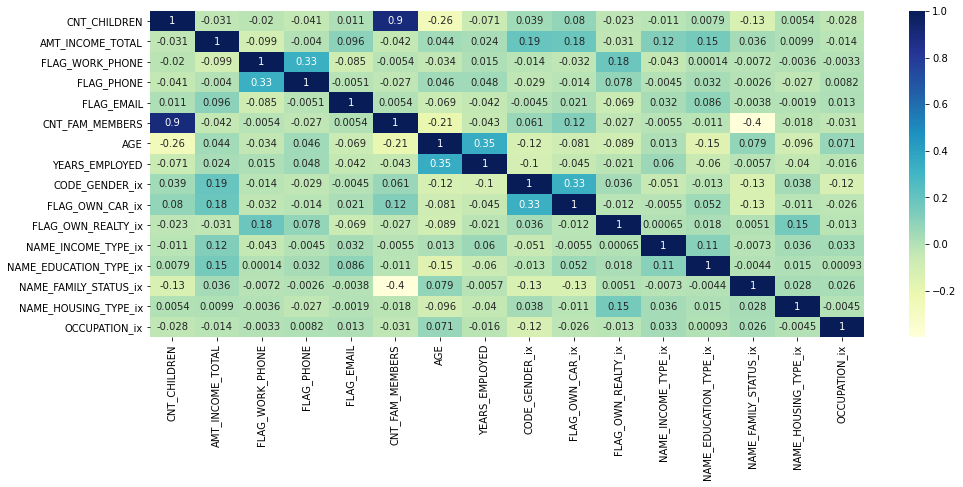

In [133]:
#plotting heatmap
plt.figure(figsize=(16,6))
sns.color_palette("Spectral", as_cmap=True)
sns.heatmap(df.corr(),annot = True,cmap="YlGnBu")
plt.show()

There is not much significant correlation between variables.

### Merged Data

In [134]:
#dropping all the parent columns from which the data is encoded.
#ID is dropped since it is illogical to include it in multivariate analysis
#FLAG_MOBIL is dropped since its reductant
#MONTHS_BALANCE column is dropped since it has nothing to do with a customer being deliquent
data=data.drop("ID","FLAG_MOBIL","CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","OCCUPATION","MONTHS_BALANCE")

In [135]:
#Converting to pandas dataframe
df=data.toPandas()

#Correlation
corr_df=df.corr()

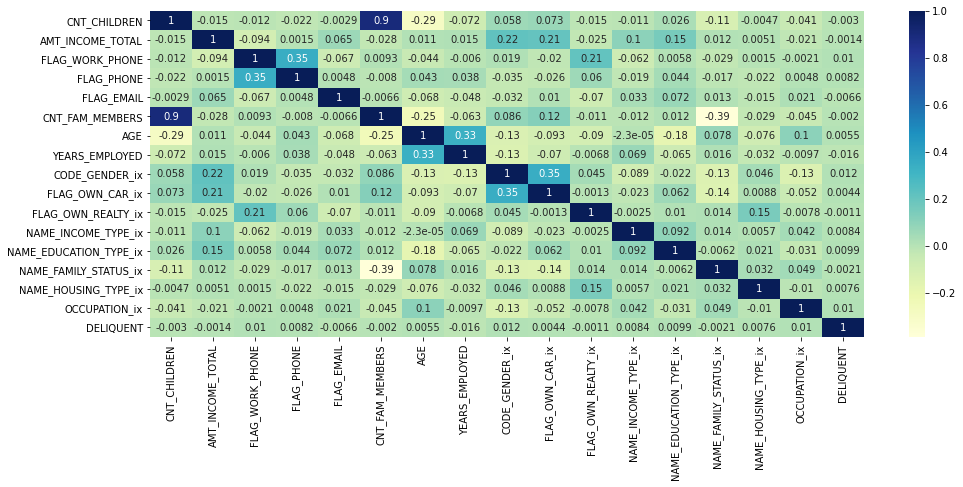

In [136]:
#plotting heatmap
plt.figure(figsize=(16,6))
sns.heatmap(df.corr(),annot = True,cmap="YlGnBu")
plt.show()

Similar to applications_record there not much significant correlation amoung variables.